# Task 2 - Image Classification via Feature Space

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.


---
---
## 0 - Import necessary libraries and informations

In [44]:
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt

from scipy.ndimage import uniform_filter
from sklearn.metrics import accuracy_score
%matplotlib inline

np.set_printoptions(precision=8)

Write down your Name and Student ID

In [45]:
## --- start your code here ----

NIM  = 1301174682
Nama = "Muhammad Ihza Mahendra"

## --- end your code here ----

---
---
## 1 - Load CIFAR-10 Dataset

* First, Obtain Cifar-10 dataset.
  There are from various source in Internet like [Keras](https://keras.io/datasets/), [Tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/datasets), or any other source
* Next you will prepare the dataset by first:
 * visualizing data
 * split into training, validation, and testing set
 * normalize data

---
### a. Import Data ***CIFAR-10***

In [46]:
import tensorflow as tf

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'forse', 'ship', 'truck']


Check your implementation

In [47]:
print('X_train.shape =',X_train.shape)
print('y_train.shape =',y_train.shape)
print('X_test.shape  =',X_test.shape)
print('y_test.shape  =',y_test.shape)

X_train.shape = (50000, 32, 32, 3)
y_train.shape = (50000, 1)
X_test.shape  = (10000, 32, 32, 3)
y_test.shape  = (10000, 1)


**Expected Output**: 
<pre>
X_train.shape = (50000, 32, 32, 3)
y_train.shape = (50000, 1)
X_test.shape  = (10000, 32, 32, 3)
y_test.shape  = (10000, 1)


---
### b. Visualizing Data


Show the first 20 images from X_train

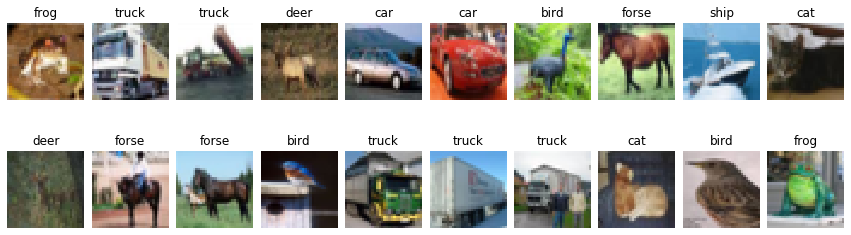

In [48]:
fig, ax = plt.subplots(2,10,figsize=(15,4.5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for j in range(0,2):
    for i in range(0, 10):
        ax[j,i].imshow(X_train[i+j*10])
        ax[j,i].set_title(classes[y_train[i+j*10,0]])
        ax[j,i].axis('off')
plt.show()

---
### c. Split Training Data

Cut the `last 10000 data` from `Training Set`, and save it as `Validation Set`

In [49]:
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')

X_val = X_train[-10000:,:]
y_val = y_train[-10000:]

X_train = X_train[:-10000, :]
y_train = y_train[:-10000]

---
---
## 2 - Feature Extraction Functions

For each image we will compute a Histogram of Oriented Gradients (HOG) as well as a color histogram using the hue channel in HSV color space. We form our final feature vector for each image by concatenating the HOG and color histogram feature vectors.

Here we already defined for you the implementation of HOG and Color Histogram. Read it carefully to understand it.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The `extract_features`
function takes a set of mages and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

---
### a. Histogram of Oriented Gradients

Roughly speaking, HOG should capture the texture of the image while ignoring color information. The code below is a modified from [skimage.feature.hog](http://pydoc.net/Python/scikits-image/0.4.2/skimage.feature.hog)

Read further: Histograms of Oriented Gradients for Human Detection, Navneet Dalal and Bill Triggs, CVPR 2005

In [50]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

In [51]:
def hog_feature(im):

    # convert rgb to grayscale if needed
    if im.ndim == 3:
        image = rgb2gray(im)
    else:
        image = np.at_least_2d(im)

    sx, sy = image.shape # image size
    orientations = 9 # number of gradient bins
    cx, cy = (8, 8) # pixels per cell

    gx = np.zeros(image.shape)
    gy = np.zeros(image.shape)

    # compute gradient on x-direction
    gx[:, :-1] = np.diff(image, n=1, axis=1) 
    # compute gradient on y-direction
    gy[:-1, :] = np.diff(image, n=1, axis=0) 

    # gradient magnitude
    grad_mag = np.sqrt(gx ** 2 + gy ** 2) 

    # gradient orientation
    grad_ori = np.arctan2(gy, (gx + 1e-15)) * (180 / np.pi) + 90 

    n_cellsx = int(np.floor(sx / cx))  # number of cells in x
    n_cellsy = int(np.floor(sy / cy))  # number of cells in y

    # compute orientations integral images
    orientation_histogram = np.zeros((n_cellsx, n_cellsy, orientations))

    for i in range(orientations):
        # create new integral image for this orientation
        # isolate orientations in this range
        temp_ori = np.where(grad_ori < 180 / orientations * (i + 1),
                            grad_ori, 0)
        temp_ori = np.where(grad_ori >= 180 / orientations * i,
                            temp_ori, 0)
        
        # select magnitudes for those orientations
        cond2 = temp_ori > 0
        temp_mag = np.where(cond2, grad_mag, 0)
        orientation_histogram[:,:,i] = uniform_filter(temp_mag, size=(cx, cy))[round(cx/2)::cx, round(cy/2)::cy].T

    return orientation_histogram.ravel()

---
### b. Color Histogram

Compared to HOG, the color histogram represents the color of the input image while ignoring texture. As a result, we expect that using both together ought to work better than using either alone. Verifying this assumption would be a good thing to try for your own interest.

In [52]:
def color_histogram_hsv(im, nbin=10, xmin=0, xmax=255, normalized=True):

    ndim = im.ndim
    bins = np.linspace(xmin, xmax, nbin+1)

    hsv = matplotlib.colors.rgb_to_hsv(im/xmax) * xmax
    imhist, bin_edges = np.histogram(hsv[:,:,0], bins=bins, density=normalized)

    imhist = imhist * np.diff(bin_edges)

    return imhist


---
### c. Extract Feature Helper Function

Given pixel data for images and several feature functions that can operate on single images, apply all feature functions to all images, concatenating the feature vectors for each image and storing the features for all images in a single matrix. This function returns an array of shape (N, F_1 + ... + F_k) where each column is the concatenation of all features for a single image.

In [53]:
def extract_features(imgs, feature_fns, verbose=False):
 
    num_images = imgs.shape[0]
    if num_images == 0:
        return np.array([])

    # Use the first image to determine feature dimensions
    feature_dims = []
    first_image_features = []
    for feature_fn in feature_fns:
        feats = feature_fn(imgs[0].squeeze())
        assert len(feats.shape) == 1, 'Feature functions must be one-dimensional'
        feature_dims.append(feats.size)
        first_image_features.append(feats)

    # Now that we know the dimensions of the features, we can allocate a single
    # big array to store all features as columns.
    total_feature_dim = sum(feature_dims)
    imgs_features = np.zeros((num_images, total_feature_dim))
    imgs_features[0] = np.hstack(first_image_features).T

    # Extract features for the rest of the images.
    for i in range(1, num_images):
        idx = 0
        for feature_fn, feature_dim in zip(feature_fns, feature_dims):
            next_idx = idx + feature_dim
            imgs_features[i, idx:next_idx] = feature_fn(imgs[i].squeeze())
            idx = next_idx
        if verbose and i % 1000 == 999:
            print('Done extracting features for %d / %d images' % (i+1, num_images))

    return imgs_features